**Importing Required Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from transformers import AdamW
from transformers import RobertaForSequenceClassification,RobertaTokenizer
from transformers import RobertaTokenizerFast,RobertaForMaskedLM,RobertaModel
from transformers import DebertaTokenizer, DebertaModel,DebertaForMaskedLM
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoConfig

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Data Visualization**

In [38]:
df = pd.read_csv('/kaggle/input/explainable-detection-of-online-sexism/edos_labelled_aggregated.csv')
#df = df[df['label_sexist'] == "sexist"]
print(df.head)

# for task A we don't need these things
df.drop(['rewire_id','label_vector'], axis=1, inplace=True)

<bound method NDFrame.head of                       rewire_id  \
0       sexism2022_english-9609   
1      sexism2022_english-16993   
2      sexism2022_english-13149   
3      sexism2022_english-13021   
4        sexism2022_english-966   
...                         ...   
19995   sexism2022_english-5228   
19996  sexism2022_english-10140   
19997   sexism2022_english-9726   
19998  sexism2022_english-13365   
19999   sexism2022_english-3523   

                                                    text label_sexist  \
0      In Nigeria, if you rape a woman, the men rape ...   not sexist   
1                                Then, she's a keeper. 😉   not sexist   
2      This is like the Metallica video where the poo...   not sexist   
3                                                 woman?   not sexist   
4                         I bet she wished she had a gun   not sexist   
...                                                  ...          ...   
19995     girls really get fucked almo

In [39]:
dfTrain=df[df['split']=="train"]
dfVal=df[df['split']=="dev"]
dfTest=df[df['split']=="test"][df['label_sexist']=="sexist"]

#df.drop(['rewire_id','label_category','label_vector'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
dfTrain.drop(['split','label_sexist'], axis=1, inplace=True)
dfVal.drop(['split','label_sexist'], axis=1, inplace=True)
dfTest.drop(['split','label_sexist'], axis=1, inplace=True)
print(dfTrain.shape,dfVal.shape,dfTest.shape)

(14000, 2) (2000, 2) (970, 2)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
print(dfTrain.head())

                                                text label_category
1                            Then, she's a keeper. 😉           none
2  This is like the Metallica video where the poo...           none
3                                             woman?           none
5  Unlicensed day care worker reportedly tells co...           none
6  [USER] Leg day is easy. Hot girls who wear min...   3. animosity


In [18]:
freq=df['label_category'].value_counts().to_dict()
print(freq)

{'none': 15146, '2. derogation': 2271, '3. animosity': 1665, '4. prejudiced discussions': 475, '1. threats, plans to harm and incitement': 443}


**Distibution of sexist and non sexist text labels**

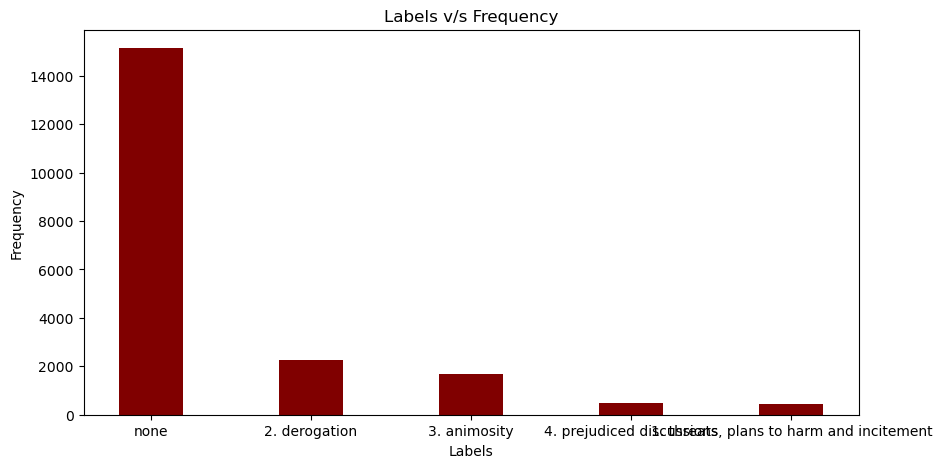

In [19]:
data = freq
types = list(data.keys())
frequency = list(data.values())

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Labels v/s Frequency")
plt.show()

**Dataset to Lists**

**Distibution of Numbers of words in each text**

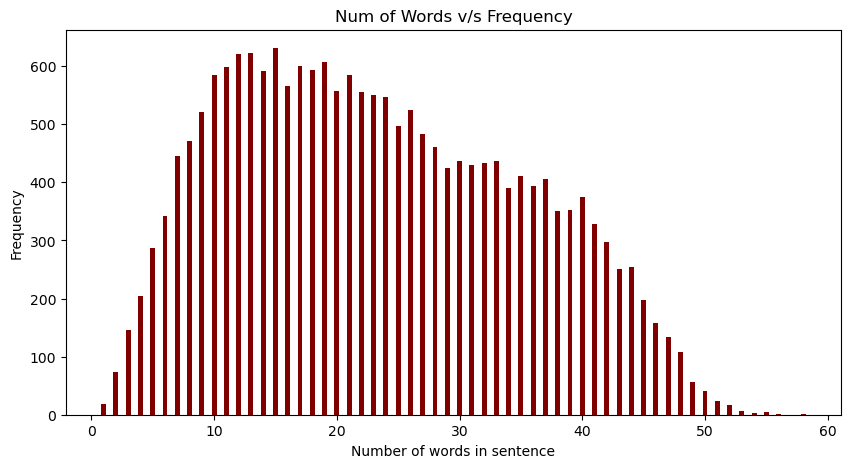

In [20]:
freq={}
texts=df['text'].tolist()
for sentence in texts:
    num_text=len(sentence.split())
    if num_text not in freq:
        freq[num_text]=0
    freq[num_text]+=1

types = list(freq.keys())
frequency = list(freq.values())

fig = plt.figure(figsize = (10, 5))
plt.bar(types, frequency, color ='maroon',width = 0.4)
plt.xlabel("Number of words in sentence")
plt.ylabel("Frequency")
plt.title("Num of Words v/s Frequency")
plt.show()

**Data Cleaning Modul** But not used

In [21]:
class DataCleaning():
    """
        Take a list of strings and preprocess strings, it preforms:
        
    """
    def __init__(self, list_data):
        self.data = list_data
        self.len = len(list_data)

    def clean_data(self):
        self.emojis_to_text()
        self.lowerCase()
        self.linkToTag()
        self.removePunctuations()
        self.removeWordsWithNumber()
        
    def tokenizer():
        pass
        
    def rootWord(self,lemmatizer=False):
        """
            Steamer is faster than lammatization.
            Steamer cut the last few words, and use the root word
            lemmatizer convert many form a word to the same word. 
            stemmer will retun 'car' for word 'caring'
            while lemmatizer return 'care' for 'caring'
        """
        if not lemmatizer:
            stemmer = PorterStemmer()
            for i in range(self.len):
                self.data[i]=" ".join([stemmer.stem(word) for word in self.data[i].split()])
        else:
            lemmatizer = WordNetLemmatizer()
            for i in range(self.len):
                self.data[i]=" ".join([lemmatizer.lemmatize(word) for word in self.data[i].split()])
        
    def removePunctuations(self):
        removePunc = re.compile(r'[^\w\s]')
        for i in range(self.len):
            self.data[i] = re.sub(removePunc, r" ",self.data[i])

    def emojis_to_text(self):
        """
            Converting image to its text meaning.
            Format: 👍 to ":thumbs_up:"
        """
        for i in range(self.len):
            self.data[i]=emoji.demojize(self.data[i])
            
    def linkToTag(self):
        """replacing web links with '<URL>'"""
        linkRegex = re.compile(r'\b(www|http|https)[^ |\n]*')

        for i in range(self.len):
            self.data[i] = re.sub(linkRegex, r"<URL>",self.data[i])
    
    def removeWordsWithNumber(self):
        """
            Zero or more number of non-whitespace then digit, 
            then Zero or more number of non-whitespace
        """
        wordNumRegex = re.compile(r'\S*\d\S*')
        for i in range(self.len):
            self.data[i]=re.sub(wordNumRegex,r"",self.data[i])
    
    def lowerCase(self):
        """
            It is sometimes important to keep the letter capital 
            as it signifies shouting in form of that word, but it
            depends on use case
        """
        for i in range(self.len):
            self.data[i]=self.data[i].lower()
            
    def removeStopword(self):
        """ Remove stopward from a string"""
        stop = stopwords.words('english')
        for i in range(self.len):
            self.data[i]=' '.join([word for word in self.data[i].split() if word not in stop])

In [22]:
#cleaning=DataCleaning(texts)
#cleaning.clean_data()
#texts=cleaning.data

**Loading Model**

In [23]:
preTrainedModel=True

if preTrainedModel == False:
    print('Loading Base model')
    roberta = RobertaModel.from_pretrained("roberta-base")
    roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    
    deberta_tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', use_fast=True, do_lower_case=False, max_len=64)
    deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
    
else:
    print("Loading Domain Adaptive Pretrained Model")
    roberta_modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt"
    roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_modelpath, use_fast = False, do_lower_case=True)
    roberta = RobertaModel.from_pretrained(roberta_modelpath)

    print("\n")
    
    deberta_modelpath="/kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta"
    deberta_tokenizer = DebertaTokenizer.from_pretrained(deberta_modelpath, use_fast = False, do_lower_case=True)
    deberta = DebertaModel.from_pretrained(deberta_modelpath)

Loading Domain Adaptive Pretrained Model


Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt2/kaggle/working/dapt and are newly initialized: ['roberta.pooler.dense

Some weights of the model checkpoint at /kaggle/input/explainable-detection-of-online-sexism/dapt-deberta/kaggle/working/dapt-deberta were not used when initializing DebertaModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Converting Train Data to Data Loader format**

In [24]:
MAX_LENGHT = 64
batch_size = 64

In [25]:
def loader(df,batch_size=128,train=True,MAX_LENGHT=64):
    """
        Given a dataframe it will return a dataloader
    """

    texts=df['text'].tolist()
    labels=df['label_category'].tolist()
    
    tokens_roberta = roberta_tokenizer.batch_encode_plus(texts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    tokens_deberta = deberta_tokenizer.batch_encode_plus(texts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    
    seq_roberta = torch.tensor(tokens_roberta['input_ids'],device=device)
    mask_roberta = torch.tensor(tokens_roberta['attention_mask'],device=device)

    seq_deberta = torch.tensor(tokens_deberta['input_ids'],device=device)
    mask_deberta = torch.tensor(tokens_deberta['attention_mask'],device=device)
    
    # 1 for sexist and 0 for non sexist
    y=[]
    for label in labels:
        if label == '1. threats, plans to harm and incitement':
            y.append(0)
        elif label == '2. derogation':
            y.append(1)
        elif label == '3. animosity':
            y.append(2)
        elif label == '4. prejudiced discussions':
            y.append(3)
        else: #not sexist
            y.append(4)
            
    y = torch.tensor(y,device=device)
    
    data = TensorDataset(seq_roberta, mask_roberta,seq_deberta, mask_deberta, y)    
    if train:
        dataloader = DataLoader(data, shuffle=True, batch_size=batch_size)
    else:
        dataloader = DataLoader(data,batch_size=batch_size,shuffle=False)

    return dataloader

In [42]:
trainDataLoader=loader(dfTrain,batch_size=batch_size,train=True)
valDataLoader= loader(dfVal,batch_size=batch_size,train=False)
#testDataLoader= loader(dfTest,batch_size=batch_size,train=False)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**Weights of base model will change**

In [27]:
for param in roberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed
    
for param in deberta.parameters():
    param.requires_grad = True   # false here means gradient need not be computed

**Model**

In [28]:
class RoBERT_Arch(nn.Module):
    def __init__(self, roberta,deberta):  
        super(RoBERT_Arch, self).__init__()
        self.roberta = roberta
        self.deberta = deberta
        self.dropout = nn.Dropout(0.1)            
        self.relu =  nn.ReLU()                    
                 
        self.fcL1=nn.Linear(768,512)
        self.fcL2=nn.Linear(512,256)    
        
        self.fc1 = nn.Linear(512,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,5)  
        
        self.softmax = nn.LogSoftmax(dim=1)       
    
    def forward(self, sent_id_roberta, mask_roberta, sent_id_deberta, mask_deberta):            
        cls_hs1 = self.roberta(sent_id_roberta, attention_mask=mask_roberta)
        cls_hs2 = self.deberta(sent_id_deberta, attention_mask=mask_deberta)
        
        hidden_state1 = cls_hs1[0]
        cls_hs1 = hidden_state1[:, 0]
        
        hidden_state2 = cls_hs2[0]
        cls_hs2 = hidden_state2[:, 0]
        
        x1=self.fcL1(cls_hs1)
        x1=self.fcL2(x1)
        
        x2=self.fcL1(cls_hs2)
        x2=self.fcL2(x2)
        
        x=torch.cat((x1,x2),1)
        
        x = self.fc1(x)
        x = self.relu(x)    
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x) #Activation function,followed by dropout , in case of relu it is same
        x = self.dropout(x)
        x = self.fc3(x)    
        x = self.softmax(x)      
        return x

model = RoBERT_Arch(roberta,deberta)
model= nn.DataParallel(model)
model = model.to(device)

**Hyperparameter**

In [29]:
optimizer = AdamW(model.parameters(),lr = 1e-5)         
cross_entropy  = nn.NLLLoss() 
epochs = 20

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**Training**

In [30]:
def train(train_dataloader,val_dataloader,useFullData=False):  
    model.train()
    total_loss=0
    dataloader=[train_dataloader]
    
    if useFullData:
        dataloader=[val_dataloader]
  
    for loader in dataloader:
        for step,batch in enumerate(tqdm(loader,position=0, leave=True)):                               
            sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta,labels = batch 
            model.zero_grad()                                          
            preds = model(sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta)          
        
            loss = cross_entropy(preds, labels)   
        
            loss.backward()                                             
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     
            optimizer.step()    
            total_loss = total_loss + loss.item()                    
    
    # checking validation accuracy
    if useFullData==False:
        model.eval()
        with torch.no_grad():
            val_preds=[]
            actual=[]
            for step,batch in enumerate(tqdm(val_dataloader,position=0, leave=True)):          
                                         
                sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta, labels = batch 
            
                preds = model(sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta)           
                
                preds = torch.argmax(preds,dim=1)
                val_preds+=preds.tolist()                         
                actual+=labels.tolist()
            valf1=f1_score(val_preds,actual,average="macro")
        return total_loss,valf1
    return total_loss,None # in this we are training on validation to get final model
    # so no use of testing on validation data itself

**Training from Train Data**

In [31]:
counter=1
lossT=[]
val_f1=[]
epochs=19 #memory is getting full
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    total_loss,f1 = train(trainDataLoader,valDataLoader)            
    lossT.append(total_loss)
    val_f1.append(f1)
    print('Training Loss: ',total_loss)
    print("Validation F1 score: ",f1)
    torch.save(model.state_dict(), 'Multi_MLP_Concat_base_dpt_joint_B'+str(counter)+".pt")
    counter+=1


 Epoch 1 / 19


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Training Loss:  217.89951473474503
Validation F1 score:  0.17374317724791724

 Epoch 2 / 19


100%|██████████| 32/32 [00:10<00:00,  2.92it/s]


Training Loss:  146.6346854865551
Validation F1 score:  0.28498305566724136

 Epoch 3 / 19


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Training Loss:  120.23605340719223
Validation F1 score:  0.292461364360966

 Epoch 4 / 19


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Training Loss:  101.37255717813969
Validation F1 score:  0.3594485998827044

 Epoch 5 / 19


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Training Loss:  87.0555862635374
Validation F1 score:  0.44221854388236714

 Epoch 6 / 19


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Training Loss:  75.18780614435673
Validation F1 score:  0.42853275552048603

 Epoch 7 / 19


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Training Loss:  63.97839713841677
Validation F1 score:  0.4943304004235082

 Epoch 8 / 19


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Training Loss:  56.82299081236124
Validation F1 score:  0.46991012921137454

 Epoch 9 / 19


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Training Loss:  50.833106972277164
Validation F1 score:  0.4973560953707946

 Epoch 10 / 19


100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Training Loss:  42.926796747371554
Validation F1 score:  0.5181716397217752

 Epoch 11 / 19


100%|██████████| 32/32 [00:11<00:00,  2.90it/s]


Training Loss:  38.53310953453183
Validation F1 score:  0.5069954095057161

 Epoch 12 / 19


100%|██████████| 32/32 [00:10<00:00,  2.94it/s]


Training Loss:  33.08326439373195
Validation F1 score:  0.5199192413682475

 Epoch 13 / 19


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Training Loss:  30.226992262527347
Validation F1 score:  0.5100635610841453

 Epoch 14 / 19


100%|██████████| 32/32 [00:10<00:00,  2.96it/s]


Training Loss:  26.33740341756493
Validation F1 score:  0.5457725557060259

 Epoch 15 / 19


100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Training Loss:  24.854567484464496
Validation F1 score:  0.5408733131370385

 Epoch 16 / 19


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Training Loss:  21.707135965581983
Validation F1 score:  0.5095203936766288

 Epoch 17 / 19


100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Training Loss:  21.972695039585233
Validation F1 score:  0.5234721901884887

 Epoch 18 / 19


100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Training Loss:  18.88350588362664
Validation F1 score:  0.5456914316712458

 Epoch 19 / 19


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Training Loss:  17.489906935486943
Validation F1 score:  0.5105472490278851


**Load Model:** Loading the model with good Macro F1 score and then using validation data as well to train over it

In [34]:
path = "/kaggle/working/Multi_MLP_Concat_base_dpt_joint_B14.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**Plotting Training Loss and Validation Macro F1 score**

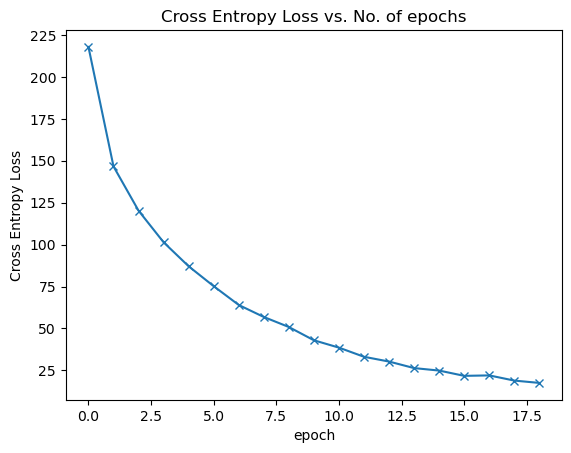

In [35]:
def plot_losses(losses):
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.title('Cross Entropy Loss vs. No. of epochs')
    
plot_losses(lossT)

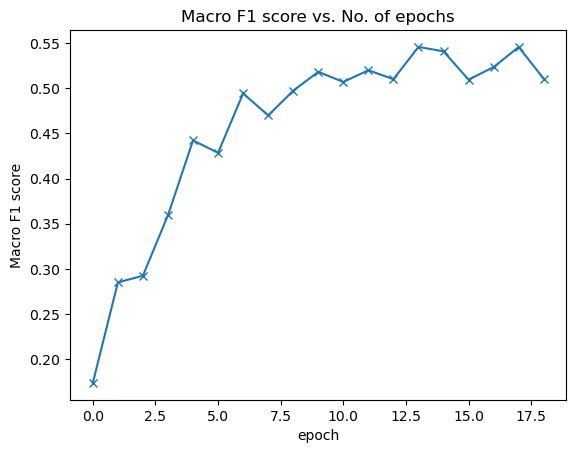

In [36]:
def plot_score(f1):
    plt.plot(f1, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Macro F1 score')
    plt.title('Macro F1 score vs. No. of epochs')
    
plot_score(val_f1)

**Now using validation data to train as well**

In [37]:
counter=1
epochs=5
for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    _L,_ = train(trainDataLoader,valDataLoader,True)


 Epoch 1 / 5


100%|██████████| 32/32 [00:31<00:00,  1.00it/s]



 Epoch 2 / 5


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]



 Epoch 3 / 5


100%|██████████| 32/32 [00:32<00:00,  1.00s/it]



 Epoch 4 / 5


100%|██████████| 32/32 [00:31<00:00,  1.00it/s]



 Epoch 5 / 5


100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


**F1 score for Test Data**

In [43]:
def testAccuracy(dfTrain):
    """
        No backpropogation. Better way to do this, is with dataloader
    """
    testTexts=dfTrain['text'].tolist()
    labels=dfTrain['label_category'].tolist()
    
    y=[]
    for label in labels:
        if label == '1. threats, plans to harm and incitement':
            y.append(0)
        elif label == '2. derogation':
            y.append(1)
        elif label == '3. animosity':
            y.append(2)
        elif label == '4. prejudiced discussions':
            y.append(3)
    
    
    tokens_test_roberta = roberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    tokens_test_deberta = deberta_tokenizer.batch_encode_plus(testTexts,max_length = MAX_LENGHT,pad_to_max_length=True,truncation=True)
    

    test_seq_roberta = torch.tensor(tokens_test_roberta['input_ids'],device=device)
    test_mask_roberta = torch.tensor(tokens_test_roberta['attention_mask'],device=device)

    test_seq_deberta = torch.tensor(tokens_test_deberta['input_ids'],device=device)
    test_mask_deberta = torch.tensor(tokens_test_deberta['attention_mask'],device=device)

    model.eval()
    with torch.no_grad():
        preds = model(test_seq_roberta, test_mask_roberta,test_seq_deberta, test_mask_deberta)
        preds = preds.detach().cpu().numpy()
        
    preds = np.argsort(preds, axis = 1)
    
    secondPreds=preds[:,-2]
    preds = preds[:,-1]
    
    label_pred=[]

    # edit this part for different number of labels
    idx=0
    for idx in range(len(preds)):
        
        label=preds[idx]
        if label >=4:#for none take second best
            label=secondPreds[idx]
        
        label_pred.append(label)        
        idx+=1
        
    testf1=f1_score(label_pred,y,average="macro")
    return testf1

In [31]:
# #checking test accuracy    
# def testAccuracy(test_dataloader,model):
#     model.eval()
#     with torch.no_grad():
#         actual=[]
#         test_preds=np.array([])
        
#         for step,batch in enumerate(tqdm(test_dataloader,position=0, leave=True)):          
                                           
#             sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta, labels = batch 
            
#             preds = model(sent_id_roberta, mask_roberta,sent_id_deberta, mask_deberta)          
#             #preds = torch.argmax(preds,dim=1)
#             #test_preds+=preds.tolist()                         
#             actual+=labels.tolist()
#             test_preds=np.append(test_preds,preds.detach().cpu().numpy())
            
#         test_preds = np.argsort(test_preds, axis = 1)
#         secondPreds=test_preds[:,-2]
#         preds = test_preds[:,-1]
        
        
#         label_pred=[]

#         # edit this part for different number of labels
#         idx=0
#         for idx in range(len(preds)):
        
#             label=preds[idx]
        
#             if label >=4:#for none take second best
#                 label=secondPreds[idx]
                
#             label_pred.append(label)
#             idx+=1
        
        
#         testf1=f1_score(label_pred,actual,average="macro")
    
#     return testf1

In [44]:
testf1=testAccuracy(dfTest)
print("Test Accuracy is: ",testf1)

Test Accuracy is:  0.5329776810525578
